# Sequence 2 Sequence Model

In [1]:
### https://towardsdatascience.com/solving-nlp-task-using-sequence2sequence-model-from-zero-to-hero-c193c1bd03d1
### https://github.com/shudima/notebooks/blob/master/NER.ipynb

In [2]:
import os
import math
import itertools
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
try:
    basestring
except NameError:
    basestring = str

In [85]:
ner_df = pd.read_csv('ner_dataset_min.csv', encoding="ISO-8859-1")
#ner_df['Word'] = ner_df['Word'].str.lower()

In [86]:
ner_df.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [87]:
sentences_words = []
sentences_tags = []
curr_sent_num = -1
current_sentence_words = []
current_sentence_tags = []
for sent_num, word, tag in ner_df[['Sentence #', 'Word', 'Tag']].values:   
    if isinstance(sent_num, basestring) and 'Sentence: ' in sent_num:
        curr_sent_num = int(sent_num.split(':')[1].strip())
        
        if current_sentence_words and current_sentence_tags:
            sentences_words.append(current_sentence_words)
            sentences_tags.append(current_sentence_tags)
            
        current_sentence_words = []
        current_sentence_tags = []
    
    current_sentence_words.append(word.encode(encoding='ISO-8859-1', ).decode(errors='replace'))
    current_sentence_tags.append(tag)

len(sentences_words), len(sentences_tags)

(1280, 1280)

In [88]:
for w, k in zip(sentences_words[123], sentences_tags[123]):
    print(w, k)


Not O
counting O
the O
latest O
death O
, O
the O
World B-org
Health I-org
Organization I-org
says O
227 O
people O
around O
the O
world O
have O
died O
from O
bird O
flu O
since O
2003 B-tim
. O


In [89]:
train_size = int(len(sentences_words) * 0.8)

train_sentences_words = sentences_words[:train_size]
train_sentences_tags = sentences_tags[:train_size]
test_sentences_words = sentences_words[train_size:]
test_sentences_tags = sentences_tags[train_size:]

print('Train:', len(train_sentences_words), len(train_sentences_tags))
print('Test:', len(test_sentences_words), len(test_sentences_tags))

Train: 1024 1024
Test: 256 256


# BoW + Cls Benchmark

In [90]:
import scipy
from sklearn.feature_extraction.text import CountVectorizer


In [91]:
def sentence_to_instances(words, tags, bow, count_vectorizer):
    X = []
    y = []
    for w, t in zip(words, tags):
        v = count_vectorizer.transform([w])[0]
        v = scipy.sparse.hstack([v, bow])
        X.append(v)
        y.append(t)
        
    return scipy.sparse.vstack(X), y

def sentences_to_instances(sentences_words, sentences_tags, count_vectorizer):
    bows = count_vectorizer.transform(map(lambda s: ' '.join(s), sentences_words))
    X = []
    y = []
    for words, tags, bow in zip(sentences_words, sentences_tags, bows):
        sent_X, sent_y = sentence_to_instances(words, tags, bow, count_vectorizer)
        X.append(sent_X)
        y += sent_y
        
    return scipy.sparse.vstack(X), np.array(y)

In [92]:
count_vectorizer = CountVectorizer(dtype='int32').fit(map(lambda s: ' '.join(s), train_sentences_words))
count_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype='int32', encoding='utf-8', input='content', lowercase=True,
        max_df=1.0, max_features=None, min_df=1, ngram_range=(1, 1),
        preprocessor=None, stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [93]:
%time train_X, train_y = sentences_to_instances(train_sentences_words, train_sentences_tags, count_vectorizer)


Wall time: 11.6 s


In [94]:
train_X.shape, train_y.shape

((22616, 8576), (22616,))

In [95]:
%time test_X, test_y = sentences_to_instances(test_sentences_words, test_sentences_tags, count_vectorizer)


Wall time: 3 s


In [96]:
test_X.shape, test_y.shape

((5858, 8576), (5858,))

In [97]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

In [98]:
clf = GradientBoostingClassifier()
clf

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [99]:
#break;

In [100]:
%time clf.fit(train_X, train_y)

Wall time: 1min 8s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [101]:
predicted = clf.predict(test_X)

In [102]:
print(classification_report(test_y, predicted))

C:\Continuum\anaconda3\envs\crtasks\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Continuum\anaconda3\envs\crtasks\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00         5
       B-eve       0.00      0.00      0.00         0
       B-geo       0.90      0.28      0.43       186
       B-gpe       0.66      0.74      0.70        85
       B-nat       0.00      0.00      0.00         3
       B-org       0.73      0.25      0.37       145
       B-per       0.78      0.30      0.43        93
       B-tim       0.86      0.59      0.70       111
       I-art       0.00      0.00      0.00         3
       I-eve       0.00      0.00      0.00         0
       I-geo       0.31      0.24      0.27        33
       I-gpe       0.00      0.00      0.00         1
       I-nat       0.00      0.00      0.00         2
       I-org       0.59      0.32      0.42        69
       I-per       0.69      0.20      0.31        89
       I-tim       0.11      0.03      0.04        38
           O       0.91      0.99      0.95      4995

   micro avg       0.90   

# Prepare for Seq2Seq

In [103]:
vocab = set(itertools.chain(*[[w for w in s] for s in train_sentences_words])) 
vocab

{'nearby',
 'pardons',
 'stay',
 'Recalled',
 'point',
 'Prosecutors',
 '2017',
 'hour-long',
 'cities',
 'Anne-Marie',
 'demonstration',
 'Irbil',
 'Warner',
 'supposed',
 'trying',
 'Inspector',
 'strategies',
 'After',
 'crime',
 'difficulty',
 'Anbar',
 'Warri',
 'rolling',
 'uncovered',
 'hospitalization',
 'returned',
 'Ron',
 'poorest',
 'mortar',
 'export',
 'extending',
 'daughter',
 'closed',
 'grave',
 'contractors',
 'Sharon',
 'deadliness',
 'protest',
 'both',
 'outlets',
 'Lithuania',
 '38-year-old',
 'practitioners',
 'social',
 'Roche',
 'delegation',
 'her',
 'Professionals',
 'Egyptian-born',
 'airlines',
 'Fatah',
 'Swazis',
 'special',
 'managers',
 'Indonesian',
 'overflowed',
 'live',
 'Bangladesh',
 'flood',
 'Rica',
 'marred',
 'ready',
 'capital',
 'stress',
 'Collemaggio',
 'environment',
 'sentence',
 'livestock',
 'abating',
 'Philip',
 'HMS',
 'director',
 'coordinated',
 'commented',
 'Latvia',
 'refer',
 'colonized',
 'stone',
 'blast',
 'need',
 'Hezbol

In [104]:
tags = set(itertools.chain(*[[w for w in s] for s in train_sentences_tags]))
tags

{'B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim',
 'O'}

In [105]:
sentences_lens = map(len, train_sentences_words)
sentences_lens = list(sentences_lens)
len(sentences_lens)

1024

In [106]:
len(vocab), len(tags), 

(4728, 17)

In [107]:
max(sentences_lens)

62

(array([ 45., 193., 258., 284., 151.,  65.,  25.,   2.,   0.,   1.]),
 array([ 4. ,  9.8, 15.6, 21.4, 27.2, 33. , 38.8, 44.6, 50.4, 56.2, 62. ]),
 <a list of 10 Patch objects>)

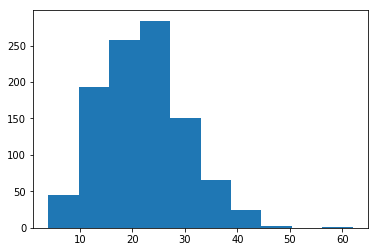

In [108]:
plt.hist(sentences_lens)

In [109]:
# MAX_LEN = 75 
MAX_LEN = max(sentences_lens)
VOCAB_SIZE = len(vocab)

In [110]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [111]:
words_tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters=[], oov_token='__UNKNOWN__')
words_tokenizer

In [112]:
words_tokenizer.fit_on_texts(map(lambda s: ' '.join(s), train_sentences_words))


In [113]:
word_index = words_tokenizer.word_index
word_index['__PADDING__'] = 0
word_index['special']

673

In [114]:
# [(k,v) for k,v in word_index.items()]

In [115]:
index_word = {i:w for w, i in word_index.items()}
print('Unique tokens:', len(word_index))

Unique tokens: 4435


In [116]:
train_sequences = words_tokenizer.texts_to_sequences(map(lambda s: ' '.join(s), train_sentences_words))
test_sequences = words_tokenizer.texts_to_sequences(map(lambda s: ' '.join(s), test_sentences_words))
print(len(train_sequences), len(test_sequences))

1024 256


In [117]:
train_sequences_padded = pad_sequences(train_sequences, maxlen=MAX_LEN)
test_sequences_padded = pad_sequences(test_sequences, maxlen=MAX_LEN)
print(train_sequences_padded.shape, test_sequences_padded.shape)

(1024, 62) (256, 62)


In [118]:
tags_tokenizer = Tokenizer(num_words=len(tags), filters='', oov_token='__UNKNOWN__', lower=False)
tags_tokenizer

In [119]:
tags_tokenizer.fit_on_texts(map(lambda s: ' '.join(s), train_sentences_tags))


In [120]:
tag_index = tags_tokenizer.word_index
tag_index['__PADDING__'] = 0
tag_index

{'__UNKNOWN__': 1,
 'O': 2,
 'B-geo': 3,
 'B-gpe': 4,
 'B-org': 5,
 'I-per': 6,
 'B-tim': 7,
 'B-per': 8,
 'I-org': 9,
 'I-geo': 10,
 'I-tim': 11,
 'B-art': 12,
 'I-gpe': 13,
 'I-art': 14,
 'B-eve': 15,
 'I-eve': 16,
 'B-nat': 17,
 'I-nat': 18,
 '__PADDING__': 0}

In [121]:
index_tag = {i:w for w, i in tag_index.items()}

index_tag_wo_padding = dict(index_tag)
index_tag_wo_padding[tag_index['__PADDING__']] = '0'
print('Unique tags:', len(tag_index))

Unique tags: 19


In [122]:
train_tags = tags_tokenizer.texts_to_sequences(map(lambda s: ' '.join(s), train_sentences_tags))
test_tags = tags_tokenizer.texts_to_sequences(map(lambda s: ' '.join(s), test_sentences_tags))
len(train_tags), len(test_tags)

(1024, 256)

In [123]:
train_tags_padded = pad_sequences(train_tags, maxlen=MAX_LEN)
test_tags_padded = pad_sequences(test_tags, maxlen=MAX_LEN)

train_tags_padded = np.expand_dims(train_tags_padded, -1)
test_tags_padded = np.expand_dims(test_tags_padded, -1)
print(train_tags_padded.shape, test_tags_padded.shape)

(1024, 62, 1) (256, 62, 1)


In [124]:
type(test_tags_padded)

numpy.ndarray

In [125]:
for w, t in zip(train_sequences_padded[123], train_tags_padded[123]):
    print(index_word[w], index_tag[t[0]])

__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
not O
counting O
the O
latest O
death O
, O
the O
world B-org
health I-org
organization 

# Bi-LSTM 

In [126]:
from keras.layers import Dense, Input, LSTM, Embedding, Bidirectional, Dropout
from keras.models import Model
from keras.initializers import Constant

In [127]:
# VOCAB_SIZE = len(vocab)
VOCAB_SIZE

4728

In [128]:
MAX_LEN

62

In [129]:
len(tag_index)

19

In [130]:
random_embedding_layer = Embedding(VOCAB_SIZE,
                                300,
                                input_length=MAX_LEN)

sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
embedded_sequences = random_embedding_layer(sequence_input)
x = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
preds = Dense(len(tag_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              #metrics=['sparse_categorical_accuracy'])
              metrics=['categorical_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 62)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 62, 300)           1418400   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 62, 128)           186880    
_________________________________________________________________
dropout_4 (Dropout)          (None, 62, 128)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 62, 32)            4128      
_________________________________________________________________
dense_8 (Dense)              (None, 62, 19)            627       
Total params: 1,610,035
Trainable params: 1,610,035
Non-trainable params: 0
_________________________________________________________________


In [131]:
train_sequences_padded.shape, test_sequences_padded.shape

((1024, 62), (256, 62))

In [132]:
train_tags_padded.shape, test_tags_padded.shape

((1024, 62, 1), (256, 62, 1))

In [133]:
for x, y in zip(train_sequences_padded, train_tags_padded):
    if len(x) != len(y):
        print(len(x), len(y))

In [134]:
for x, y in zip(test_sequences_padded, test_tags_padded):
    if len(x) != len(y):
        print(len(x), len(y))

In [135]:
%time model.fit(train_sequences_padded, train_tags_padded, batch_size=32, epochs=10, \
                validation_data=(test_sequences_padded, test_tags_padded))

Train on 1024 samples, validate on 256 samples
Epoch 1/10
1024/1024 [==============================] - ETA: 1:38 - loss: 2.9383 - categorical_accuracy: 0.00 - ETA: 49s - loss: 2.9139 - categorical_accuracy: 0.3007 - ETA: 33s - loss: 2.8906 - categorical_accuracy: 0.443 - ETA: 24s - loss: 2.8677 - categorical_accuracy: 0.519 - ETA: 19s - loss: 2.8399 - categorical_accuracy: 0.580 - ETA: 16s - loss: 2.8145 - categorical_accuracy: 0.609 - ETA: 14s - loss: 2.7814 - categorical_accuracy: 0.639 - ETA: 12s - loss: 2.7458 - categorical_accuracy: 0.661 - ETA: 10s - loss: 2.7062 - categorical_accuracy: 0.679 - ETA: 9s - loss: 2.6623 - categorical_accuracy: 0.696 - ETA: 8s - loss: 2.6142 - categorical_accuracy: 0.71 - ETA: 7s - loss: 2.5519 - categorical_accuracy: 0.72 - ETA: 6s - loss: 2.4817 - categorical_accuracy: 0.74 - ETA: 6s - loss: 2.4058 - categorical_accuracy: 0.76 - ETA: 5s - loss: 2.3392 - categorical_accuracy: 0.77 - ETA: 5s - loss: 2.2753 - categorical_accuracy: 0.79 - ETA: 4s - los

1024/1024 [==============================] - ETA: 3s - loss: 0.1922 - categorical_accuracy: 0.63 - ETA: 3s - loss: 0.1870 - categorical_accuracy: 0.63 - ETA: 3s - loss: 0.1994 - categorical_accuracy: 0.63 - ETA: 3s - loss: 0.2044 - categorical_accuracy: 0.62 - ETA: 2s - loss: 0.1993 - categorical_accuracy: 0.63 - ETA: 2s - loss: 0.1952 - categorical_accuracy: 0.63 - ETA: 2s - loss: 0.1920 - categorical_accuracy: 0.64 - ETA: 2s - loss: 0.1889 - categorical_accuracy: 0.64 - ETA: 2s - loss: 0.1888 - categorical_accuracy: 0.64 - ETA: 2s - loss: 0.1894 - categorical_accuracy: 0.64 - ETA: 2s - loss: 0.1922 - categorical_accuracy: 0.64 - ETA: 2s - loss: 0.1908 - categorical_accuracy: 0.65 - ETA: 2s - loss: 0.1910 - categorical_accuracy: 0.65 - ETA: 1s - loss: 0.1900 - categorical_accuracy: 0.65 - ETA: 1s - loss: 0.1917 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1938 - categorical_accuracy: 0.65 - ETA: 1s - loss: 0.1949 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1961 - categorical_

1024/1024 [==============================] - ETA: 4s - loss: 0.1116 - categorical_accuracy: 0.63 - ETA: 4s - loss: 0.1162 - categorical_accuracy: 0.63 - ETA: 4s - loss: 0.1101 - categorical_accuracy: 0.64 - ETA: 4s - loss: 0.1155 - categorical_accuracy: 0.63 - ETA: 4s - loss: 0.1142 - categorical_accuracy: 0.63 - ETA: 3s - loss: 0.1080 - categorical_accuracy: 0.63 - ETA: 3s - loss: 0.1062 - categorical_accuracy: 0.63 - ETA: 3s - loss: 0.1057 - categorical_accuracy: 0.64 - ETA: 3s - loss: 0.1057 - categorical_accuracy: 0.63 - ETA: 3s - loss: 0.1032 - categorical_accuracy: 0.63 - ETA: 2s - loss: 0.1036 - categorical_accuracy: 0.63 - ETA: 2s - loss: 0.1046 - categorical_accuracy: 0.63 - ETA: 2s - loss: 0.1054 - categorical_accuracy: 0.63 - ETA: 2s - loss: 0.1057 - categorical_accuracy: 0.63 - ETA: 2s - loss: 0.1038 - categorical_accuracy: 0.63 - ETA: 2s - loss: 0.1020 - categorical_accuracy: 0.64 - ETA: 2s - loss: 0.1016 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1013 - categorical_

# Evaluation

In [136]:
from seqeval.metrics import classification_report, f1_score

In [137]:
%time lstm_predicted = model.predict(test_sequences_padded)

Wall time: 508 ms


In [138]:
lstm_predicted_tags = []
bow_predicted_tags = []
for s, s_pred in zip(test_sentences_words, lstm_predicted):
    tags = np.argmax(s_pred, axis=1)
    tags = list(map(index_tag_wo_padding.get, tags))[-len(s):]
    lstm_predicted_tags.append(tags)
    
    bow_vector, _ = sentences_to_instances([s], [['x']*len(s)], count_vectorizer)
    bow_predicted = clf.predict(bow_vector)[0]
    bow_predicted_tags.append(bow_predicted)
    

In [139]:
lstm_predicted_tags = []
bow_predicted_tags = []
for s, s_pred in zip(test_sentences_words, lstm_predicted):
    tags = np.argmax(s_pred, axis=1)
    tags = list(map(index_tag_wo_padding.get,tags))[-len(s):]
    lstm_predicted_tags.append(tags)
    
    bow_vector, _ = sentences_to_instances([s], [['x']*len(s)], count_vectorizer)
    bow_predicted = clf.predict(bow_vector)[0]
    bow_predicted_tags.append(bow_predicted)
    

In [140]:
print('LSTM')
print('='*15)
print(classification_report(test_sentences_tags, lstm_predicted_tags))
print()
print('BOW')
print('='*15)
print(classification_report(test_sentences_tags, bow_predicted_tags))

LSTM
             precision    recall  f1-score   support

        tim       0.74      0.49      0.59       111
        per       0.45      0.24      0.31        93
        org       0.37      0.19      0.25       145
        gpe       0.44      0.81      0.57        85
        geo       0.48      0.38      0.43       186
        nat       0.00      0.00      0.00         3
        art       0.00      0.00      0.00         5

avg / total       0.48      0.39      0.41       628


BOW
             precision    recall  f1-score   support

        tim       0.00      0.00      0.00       111
        per       0.00      0.00      0.00        93
        org       0.00      0.00      0.00       145
        gpe       0.00      0.00      0.00        85
        geo       0.00      0.00      0.00       186
        nat       0.00      0.00      0.00         3
        art       0.00      0.00      0.00         5

avg / total       0.00      0.00      0.00       628



In [141]:
print('LSTM:', f1_score(test_sentences_tags, lstm_predicted_tags))
print('BOW:', f1_score(test_sentences_tags, bow_predicted_tags))

LSTM: 0.42995594713656393
BOW: 0


# Pre Trained Embedding

In [142]:
os.getcwd()

'C:\\Continuum\\anaconda3\\envs\\crtasks\\notebooks\\SequenceModels'

In [143]:
GLOVE_DIR = os.getcwd() + '\\glove.6B\\'

In [144]:
embeddings = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'), encoding="ISO-8859-1") as f:
    for line in f:
        values = line.split()
        word = values[0]
        if len(values[1:]) == 300:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings[word] = coefs

        #print('# values:',  len(values[1:]))

print('# vectors:',  len(embeddings))

# vectors: 399883


In [145]:
# prepare embedding matrix
num_words = min(VOCAB_SIZE, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, 300))
for word, i in word_index.items():
    if i >= VOCAB_SIZE:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [146]:
pretrained_embedding_layer = Embedding(VOCAB_SIZE,
                                300,
                                embeddings_initializer=Constant(embedding_matrix),
                                input_length=MAX_LEN,
                                trainable=False)

sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
embedded_sequences = pretrained_embedding_layer(sequence_input)
x = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
preds = Dense(len(tag_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              #metrics=['sparse_categorical_accuracy'])
              metrics=['categorical_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 62)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 62, 300)           1418400   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 62, 128)           186880    
_________________________________________________________________
dropout_5 (Dropout)          (None, 62, 128)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 62, 32)            4128      
_________________________________________________________________
dense_10 (Dense)             (None, 62, 19)            627       
Total params: 1,610,035
Trainable params: 191,635
Non-trainable params: 1,418,400
____________________________________________________________

In [147]:
%time model.fit(train_sequences_padded, train_tags_padded, batch_size=32, epochs=10,\
                validation_data=(test_sequences_padded, test_tags_padded))

Train on 1024 samples, validate on 256 samples
Epoch 1/10
1024/1024 [==============================] - ETA: 1:32 - loss: 2.8738 - categorical_accuracy: 0.0000e+ - ETA: 45s - loss: 2.8185 - categorical_accuracy: 0.0491     - ETA: 30s - loss: 2.7630 - categorical_accuracy: 0.091 - ETA: 22s - loss: 2.7189 - categorical_accuracy: 0.123 - ETA: 17s - loss: 2.6737 - categorical_accuracy: 0.146 - ETA: 14s - loss: 2.6244 - categorical_accuracy: 0.160 - ETA: 12s - loss: 2.5808 - categorical_accuracy: 0.169 - ETA: 10s - loss: 2.5353 - categorical_accuracy: 0.176 - ETA: 9s - loss: 2.4943 - categorical_accuracy: 0.182 - ETA: 8s - loss: 2.4466 - categorical_accuracy: 0.18 - ETA: 7s - loss: 2.4161 - categorical_accuracy: 0.18 - ETA: 6s - loss: 2.3836 - categorical_accuracy: 0.19 - ETA: 5s - loss: 2.3519 - categorical_accuracy: 0.19 - ETA: 5s - loss: 2.3284 - categorical_accuracy: 0.19 - ETA: 4s - loss: 2.2992 - categorical_accuracy: 0.19 - ETA: 4s - loss: 2.2756 - categorical_accuracy: 0.19 - ETA: 3s

1024/1024 [==============================] - ETA: 2s - loss: 0.2124 - categorical_accuracy: 0.66 - ETA: 2s - loss: 0.1821 - categorical_accuracy: 0.64 - ETA: 2s - loss: 0.1743 - categorical_accuracy: 0.64 - ETA: 2s - loss: 0.1674 - categorical_accuracy: 0.64 - ETA: 2s - loss: 0.1723 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1695 - categorical_accuracy: 0.65 - ETA: 1s - loss: 0.1631 - categorical_accuracy: 0.65 - ETA: 1s - loss: 0.1667 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1688 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1686 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1678 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1666 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1650 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1626 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1615 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1589 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1588 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1563 - categorical_

1024/1024 [==============================] - ETA: 2s - loss: 0.1109 - categorical_accuracy: 0.63 - ETA: 2s - loss: 0.1115 - categorical_accuracy: 0.64 - ETA: 2s - loss: 0.1236 - categorical_accuracy: 0.63 - ETA: 2s - loss: 0.1161 - categorical_accuracy: 0.63 - ETA: 2s - loss: 0.1211 - categorical_accuracy: 0.64 - ETA: 2s - loss: 0.1138 - categorical_accuracy: 0.64 - ETA: 2s - loss: 0.1140 - categorical_accuracy: 0.64 - ETA: 2s - loss: 0.1113 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1104 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1090 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1060 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1079 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1086 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1081 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1081 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1076 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1070 - categorical_accuracy: 0.64 - ETA: 1s - loss: 0.1035 - categorical_

In [148]:
lstm_predicted = model.predict(test_sequences_padded)

In [149]:
lstm_predicted_tags = []
for s, s_pred in zip(test_sentences_words, lstm_predicted):
    tags = np.argmax(s_pred, axis=1)
    tags = list(map(index_tag_wo_padding.get,tags))[-len(s):]
    lstm_predicted_tags.append(tags)

In [150]:
print('LSTM + Pretrained Embbeddings')
print('='*15)
print(classification_report(test_sentences_tags, lstm_predicted_tags))

LSTM + Pretrained Embbeddings
             precision    recall  f1-score   support

        tim       0.66      0.53      0.59       111
        per       0.46      0.34      0.40        93
        org       0.35      0.19      0.24       145
        gpe       0.51      0.88      0.65        85
        geo       0.66      0.46      0.54       186
        nat       0.00      0.00      0.00         3
        art       0.00      0.00      0.00         5

avg / total       0.53      0.44      0.47       628



In [151]:
print('LSTM+Glove:', f1_score(test_sentences_tags, lstm_predicted_tags))

LSTM+Glove: 0.4744027303754266


# ELMo

In [152]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
from keras.layers import Lambda

In [153]:
sess = tf.Session()
K.set_session(sess)

In [160]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=False)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

INFO:tensorflow:Initialize variable module_1/aggregation/scaling:0 from checkpoint b'C:\\Users\\Praveen.TN\\AppData\\Local\\Temp\\tfhub_modules\\9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d\\variables\\variables' with aggregation/scaling
INFO:tensorflow:Initialize variable module_1/aggregation/weights:0 from checkpoint b'C:\\Users\\Praveen.TN\\AppData\\Local\\Temp\\tfhub_modules\\9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d\\variables\\variables' with aggregation/weights
INFO:tensorflow:Initialize variable module_1/bilm/CNN/W_cnn_0:0 from checkpoint b'C:\\Users\\Praveen.TN\\AppData\\Local\\Temp\\tfhub_modules\\9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d\\variables\\variables' with bilm/CNN/W_cnn_0
INFO:tensorflow:Initialize variable module_1/bilm/CNN/W_cnn_1:0 from checkpoint b'C:\\Users\\Praveen.TN\\AppData\\Local\\Temp\\tfhub_modules\\9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d\\variables\\variables' with bilm/CNN/W_cnn_1
INFO:tensorflow:Initialize variable module_1/bilm/CNN/W_cnn_2:0 from checkpo

INFO:tensorflow:Initialize variable module_1/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0 from checkpoint b'C:\\Users\\Praveen.TN\\AppData\\Local\\Temp\\tfhub_modules\\9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d\\variables\\variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias
INFO:tensorflow:Initialize variable module_1/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0 from checkpoint b'C:\\Users\\Praveen.TN\\AppData\\Local\\Temp\\tfhub_modules\\9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d\\variables\\variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel
INFO:tensorflow:Initialize variable module_1/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0 from checkpoint b'C:\\Users\\Praveen.TN\\AppData\\Local\\Temp\\tfhub_modules\\9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d\\variables\\variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel
INFO:tensorflow:Initialize variable module_1/bilm/RNN_1/RNN/MultiRNNCe

In [161]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(32*[MAX_LEN])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [162]:
elmo_embedding_layer = Lambda(ElmoEmbedding, output_shape=(MAX_LEN, 1024))

#sequence_input = Input(shape=(MAX_LEN,), dtype=tf.string)
sequence_input = Input(shape=(MAX_LEN,), dtype=tf.string)

embedded_sequences = elmo_embedding_layer(sequence_input)
x = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
preds = Dense(len(tag_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 62)                0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 62, 1024)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 62, 128)           557568    
_________________________________________________________________
dropout_7 (Dropout)          (None, 62, 128)           0         
_________________________________________________________________
dense_13 (Dense)             (None, 62, 32)            4128      
_________________________________________________________________
dense_14 (Dense)             (None, 62, 19)            627       
Total params: 562,323
Trainable params: 562,323
Non-trainable params: 0
_________________________________________________________________


In [163]:
new_train_words_padded = [[index_word[w] for w in s] for s in train_sequences_padded]
new_test_words_padded = [[index_word[w] for w in s] for s in test_sequences_padded]

In [164]:
#break

In [165]:
new_train_words_padded = np.array(new_train_words_padded[:32*32])
new_train_tags_padded = train_tags_padded[:32*32]

new_test_words_padded = np.array(new_test_words_padded[:8*32])
new_test_tags_padded = test_tags_padded[:8*32]


new_train_words_padded.shape, new_train_tags_padded.shape, new_test_words_padded.shape, new_test_tags_padded.shape

((1024, 62), (1024, 62, 1), (256, 62), (256, 62, 1))

In [166]:
model.fit(new_train_words_padded, new_train_tags_padded,
          batch_size=32,
          epochs=4,
          validation_data=(new_test_words_padded, new_test_tags_padded))

Train on 1024 samples, validate on 256 samples
Epoch 1/4
1024/1024 [==============================] - ETA: 7:30 - loss: 3.1271 - categorical_accuracy: 0.00 - ETA: 6:32 - loss: 2.6629 - categorical_accuracy: 0.33 - ETA: 6:10 - loss: 2.3536 - categorical_accuracy: 0.46 - ETA: 5:55 - loss: 2.1054 - categorical_accuracy: 0.53 - ETA: 5:40 - loss: 1.9264 - categorical_accuracy: 0.58 - ETA: 5:25 - loss: 1.7854 - categorical_accuracy: 0.59 - ETA: 5:11 - loss: 1.6585 - categorical_accuracy: 0.61 - ETA: 5:01 - loss: 1.5413 - categorical_accuracy: 0.62 - ETA: 4:50 - loss: 1.4496 - categorical_accuracy: 0.63 - ETA: 4:42 - loss: 1.3649 - categorical_accuracy: 0.63 - ETA: 4:32 - loss: 1.2884 - categorical_accuracy: 0.63 - ETA: 4:22 - loss: 1.2168 - categorical_accuracy: 0.63 - ETA: 4:09 - loss: 1.1592 - categorical_accuracy: 0.63 - ETA: 3:55 - loss: 1.1034 - categorical_accuracy: 0.64 - ETA: 3:42 - loss: 1.0506 - categorical_accuracy: 0.64 - ETA: 3:29 - loss: 1.0083 - categorical_accuracy: 0.64 - ET

In [167]:
lstm_predicted = model.predict(new_test_words_padded)

In [169]:
lstm_predicted_tags = []
for s, s_pred in zip(test_sentences_words[:299*32], lstm_predicted):
    tags = np.argmax(s_pred, axis=1)
    tags = list(map(index_tag_wo_padding.get,tags))[-len(s):]
    lstm_predicted_tags.append(tags)

In [170]:
print('ELMo')
print('='*15)
print(classification_report(test_sentences_tags, lstm_predicted_tags))

ELMo
             precision    recall  f1-score   support

        tim       0.76      0.49      0.59       111
        per       0.44      0.29      0.35        93
        org       0.31      0.08      0.12       145
        gpe       0.35      0.74      0.47        85
        geo       0.53      0.47      0.50       186
        nat       0.00      0.00      0.00         3
        art       0.00      0.00      0.00         5

avg / total       0.48      0.39      0.40       628



In [171]:
print('ELMo:', f1_score(test_sentences_tags[:299*32], lstm_predicted_tags))

ELMo: 0.2965222696766321


---